# Introduction

.....


Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!which python

/home/adripinto/.local/share/virtualenvs/social-media-analysis-B4dJjkUW/bin/python


# Install dependencies:

In [2]:
# install_packages = True
# if install_packages:
#     !conda install tensorflow=2 -y
#     !conda install -c anaconda pandas -y
#     !conda install -c conda-forge tensorflow-hub -y
#     !conda install -c akode html2text -y
#     !conda install -c conda-forge tqdm -y
#     !conda install -c anaconda scikit-learn -y
#     !conda install -c conda-forge matplotlib -y
#     !conda install -c anaconda seaborn -y

# Imports

In [3]:
#imports
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
from html2text import HTML2Text
from tqdm import tqdm
import re
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas print options
This will improve readability of printed pandas dataframe.


In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

data_path: In this path put the data you have downloaded with YouTube Data Tools. 
output_path: Tghe files generated in this notebook will be saved here.

url_dict: URLs to models on Tensorflow hub are saved here. Other models are available there.
model_type: Define which model you would like to use. Choose one from url_dict

new_embeddings: If this is true, new embeddings will be generated and saved at output_path. Otherwise, embeddings are loaded from Disc.




In [5]:
data_path = './data/videoinfo_rcHCretMIZU_2020_11_30-16_16_17_comments.tab'
output_path = "./output/"

new_embeddings = True

url_dict = {
            'Transformer' : "https://tfhub.dev/google/universal-sentence-encoder-large/5",
            'DAN' : "https://tfhub.dev/google/universal-sentence-encoder/4",
            'Transformer_Multilingual': "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"
}

model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

## Create output directory
Try to create the directory defined by output_path

In [6]:
try:
   os.mkdir(output_path)
except OSError:
  print ("Creation of the directory %s failed" % output_path)
else:
  print ("Successfully created the directory %s " % output_path)


Successfully created the directory ./output/ 


# Load Data
Load you data as a pandas dataframe

In [7]:
if new_embeddings:
    data = pd.read_csv(data_path,sep='\t',header=(0))
    data.head()

# Preprocessing
Preprocess your data:
- Drop empty rows
- Drop unused columns

In [8]:
if new_embeddings:
    data = data.dropna(subset=['text', 'authorName']) # drop rows with no content
    data=data.drop(['id', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1) # drop unused columns
    data.head()

- remove HTML-tags, links and usernames

In [9]:
if new_embeddings:
    # Remove HTML tags
    tqdm.pandas()
    h = HTML2Text()
    h.ignore_links = True
    data['cleaned'] = data['text'].progress_apply(lambda x: h.handle(x))
    print( "Removed HTML Tags.")

    # Remove links
    http_link_pattern = r'http\S+'
    bitly_link_pattern = r'bit.ly/\S+'
    data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
    data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
    print( "Removed Links.")

    # Remove user names
    keep_names = ["earth", "Tide", "Geologist", "A Person", "Titanic", "adventure", "Sun", "The United States Of America"] # user names we want to keep
    user_names = [name for name in data['authorName'].unique() if (len(name)> 3 and name not in keep_names)]
    data['cleaned'] = data['cleaned'].str.replace('|'.join(map(re.escape, user_names)), '')
    print( "Removed user names.")

/home/adripinto/.local/share/virtualenvs/social-media-analysis-B4dJjkUW/lib/python3.8/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 146/146 [00:00<00:00, 2840.11it/s]

Removed HTML Tags.
Removed Links.
Removed user names.


# Save or Load preprocessed data

Save your data afte preprocessing, or load preprocessed data from disc.

In [10]:
if new_embeddings:
  data.to_pickle(output_path+'data_preprocessed'+'.pkl')
else:
  data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
data.head()

,publishedAt,authorName,text,isReply,cleaned
0,2020-06-16 23:39:58,Petjo Bedet,"Such a gifted child, and English is her second language!",0,"Such a gifted child, and English is her second language!\n\n"
1,2020-06-14 08:42:59,John- 117,Why is it that the internet tends to label Naomi or title her as the &quot;Anti-Greta-Thunberg&quot;? What has she done or said that would cause her to deserve such title? What has she done against Greta Thunberg? NOTHING!!!<br />Naomi does not deserve such slanderous title. She is not against Greta Thunberg.,0,"Why is it that the internet tends to label Naomi or title her as the ""Anti-\nGreta-Thunberg""? What has she done or said that would cause her to deserve\nsuch title? What has she done against Greta Thunberg? NOTHING!!! \nNaomi does not deserve such slanderous title. She is not against Greta\nThunberg.\n\n"
2,2020-06-08 16:44:20,Scott Wesley,Naomi!!!!!! Wonderful stuff.,0,Naomi!!!!!! Wonderful stuff.\n\n
3,2020-06-05 16:06:06,Jan Klaus Pol,A really intelligent girl. My respect.,0,A really intelligent girl. My respect.\n\n
4,2020-05-26 08:14:14,Giles Mitchell,This is daft. Greta has repeatedly stated that she wants people to listen to the science on the realities of climate change. Sorry but this is a classic strawman argument - you raise a false idea as fact about your opponent and then proceed to tear it down. She and the climate protesters aren’t saying listen to their private findings instead of what the scientific community say - they are EXACTLY urging people to look at the science. Naomi’s alternative right wing “version” on climate change denial masquerading as sensible reasoning is not aligned to the consensus among the scientific community. Naomi sorry but your personal interpretations don’t override what the scientific community are telling us and if you want people to ignore them and listen to you - isn’t that exactly what you accused Greta and her hysterical fans from doing ? If you have alternative evidence then point to your sources so they can be examined.,0,This is daft. Greta has repeatedly stated that she wants people to listen to\nthe science on the realities of climate change. Sorry but this is a classic\nstrawman argument - you raise a false idea as fact about your opponent and\nthen proceed to tear it down. She and the climate protesters aren’t saying\nlisten to their private findings instead of what the scientific community say\n- they are EXACTLY urging people to look at the science. Naomi’s alternative\nright wing “version” on climate change denial masquerading as sensible\nreasoning is not aligned to the consensus among the scientific community.\nNaomi sorry but your personal interpretations don’t override what the\nscientific community are telling us and if you want people to ignore them and\nlisten to you - isn’t that exactly what you accused Greta and her hysterical\nfans from doing ? If you have alternative evidence then point to your sources\nso they can be examined.\n\n


# Produce Text Embeddings with Universal Sentence Encoder

## Load Model
Load the model from TF-hub

In [11]:
hub_url = url_dict[model_type]
if new_embeddings:
  print("Loading model. This will take some time...")
  embed = hub.load(hub_url)

Loading model. This will take some time...


## Embed Documents
Produce embeddings of your documents.

In [12]:
if new_embeddings:
    for k,g in data.groupby(np.arange(len(data))//200):
        if k == 0:
            embeddings = embed(g['cleaned'])
        else:
            embeddings_new = embed(g['cleaned'])
            embeddings = tf.concat(values=[embeddings,embeddings_new],axis = 0)
            print(k , end =" ")
    print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

    np.save(output_path+'/embeddings'+model_type+'.npy', embeddings, allow_pickle=True, fix_imports=True)
else:
    embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

embeddings.shape

The embeddings vector is of fixed length 512


TensorShape([146, 512])

## Calculate Similarity Matrix with angular distance

'Following Cer et al. (2018), we first compute
the sentence embeddings u, v for an STS sentence
pair, and then score the sentence pair similarity
based on the angular distance between the two
embedding vectors  d = − arccos (uv/||u|| ||v||).'

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity
cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

[[1.         0.10519156 0.18776809 ... 0.00436522 0.06874406 0.1673601 ]
 [0.10519156 1.0000002  0.4805107  ... 0.11099114 0.26576853 0.21884125]
 [0.18776809 0.4805107  0.99999994 ... 0.02403464 0.3100128  0.11051565]
 ...
 [0.00436522 0.11099114 0.02403464 ... 1.0000001  0.11144111 0.0366616 ]
 [0.06874406 0.26576853 0.3100128  ... 0.11144111 0.9999999  0.03935729]
 [0.1673601  0.21884125 0.11051565 ... 0.0366616  0.03935729 1.0000001 ]]


# Plots Similarity 
Plot and print a heat map showing the semantic contextual similarity between comments.

/home/adripinto/.local/share/virtualenvs/social-media-analysis-B4dJjkUW/lib/python3.8/site-packages/seaborn/matrix.py:311: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/adripinto/.local/share/virtualenvs/social-media-analysis-B4dJjkUW/lib/python3.8/site-packages/seaborn/matrix.py:311: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


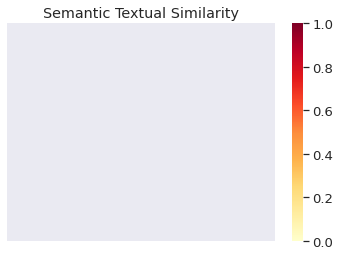

In [14]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

num_samples = 5
off_set = 10000

plot_similarity(data.iloc[off_set:off_set+num_samples]['cleaned'], embeddings[off_set:off_set+num_samples], 90)

# Show neighbours of a comment 
Define which comment to analyze

In [15]:
comment_index = 13
comment = data["cleaned"][comment_index]
comment_list = data["cleaned"].tolist()
print(comment)

AHHHahaha! What a disaster for the bankrupt Heartland Institute. Naomi's mom
Karoline is an attorney who works with Alternative für Deutschland, Germany's
far-right nationalist party with ties to neo-Nazis. Ms. Seibt's American
rightwing debut, at a CPAC sideshow promoting Our Bright Coal-Choked Future,
was marred by the news that she has her own far-right baggage. Seibt took part
in a YouTube discussion following a deadly attack on a synagogue in October,
in which she had some thoughts about how Jews get way too much sympathy in
Germany. She also explained she's a great big fan of Canadian wingnut race-
baiter and manosphere hero Stephan Molyneux, whom she considers an
"inspiration." So all in all, not a good roll-out for the Anti-Greta.




Print similar comments.

In [16]:
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]


for i, value in enumerate(get_top_similar(comment, comment_list, cosine_similarity_matrix, 20)):
  print("Top similar comment {}: {}".format(i+1, value))

Top similar comment 1: AHHHahaha! What a disaster for the bankrupt Heartland Institute. Naomi's mom
Karoline is an attorney who works with Alternative für Deutschland, Germany's
far-right nationalist party with ties to neo-Nazis. Ms. Seibt's American
rightwing debut, at a CPAC sideshow promoting Our Bright Coal-Choked Future,
was marred by the news that she has her own far-right baggage. Seibt took part
in a YouTube discussion following a deadly attack on a synagogue in October,
in which she had some thoughts about how Jews get way too much sympathy in
Germany. She also explained she's a great big fan of Canadian wingnut race-
baiter and manosphere hero Stephan Molyneux, whom she considers an
"inspiration." So all in all, not a good roll-out for the Anti-Greta.


Top similar comment 2: AHHHahaha! What a disaster for the bankrupt Heartland Institute. Naomi's mom
Karoline is an attorney who works with Alternative für Deutschland, Germany's
far-right nationalist party with ties to neo-Naz